In [1]:
dataset_path = r'D:\repo\Stock\Seasonal-Stock\dataset\CVE\data\CVE.csv'

import pandas as pd
# import dataset
dataset = pd.read_csv(dataset_path)
dataset
# remove unnamed:0
dataset = dataset.drop(['Unnamed: 0'], axis=1)
dataset
cols_to_add = ['week', 'month', 'year', 'month and week', 'quarter', 'max loss', 'max gain']
# add cols
for col in cols_to_add:
    dataset[col] = -1

dataset

,close,high,low,trade_count,open,volume,vwap,timestamp,unixTime,week,month,year,month and week,quarter,max loss,max gain
0,11.66,12.610,11.480,85311,12.53,15200047,12.054332,2016-01-04 05:00:00+00:00,1.451912e+09,-1,-1,-1,-1,-1,-1,-1
1,11.79,12.090,11.180,85091,11.66,13550593,11.531090,2016-01-11 05:00:00+00:00,1.452517e+09,-1,-1,-1,-1,-1,-1,-1
2,12.59,12.820,10.760,82374,11.78,12258791,11.881506,2016-01-18 05:00:00+00:00,1.453122e+09,-1,-1,-1,-1,-1,-1,-1
3,12.29,12.650,11.460,125681,12.25,18898733,12.151660,2016-01-25 05:00:00+00:00,1.453727e+09,-1,-1,-1,-1,-1,-1,-1
4,11.78,12.440,11.150,105128,12.10,17994866,11.831673,2016-02-01 05:00:00+00:00,1.454332e+09,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,17.67,18.305,17.050,119715,18.25,25793483,17.760627,2023-11-20 05:00:00+00:00,1.700485e+09,-1,-1,-1,-1,-1,-1,-1
412,17.71,18.150,17.415,181141,17.61,42579546,17.725974,2023-11-27 05:00:00+00:00,1.701090e+09,-1,-1,-1,-1,-1,-1,-1
413,16.29,17.590,15.870,201278,17.46,51178718,16.497954,2023-12-04 05:00:00+00:00,1.701695e+09,-1,-1,-1,-1,-1,-1,-1
414,16.72,16.750,15.550,176196,16.22,64896390,16.175535,2023-12-11 05:00:00+00:00,1.702300e+09,-1,-1,-1,-1,-1,-1,-1


In [2]:
# calculate week of month from timestamp date
from datetime import datetime
from math import ceil
def week_of_month(dt):
    """ Calculates the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))
    

def month_of_year(dt):
    return dt.month

def quarter(dt):
    return int(ceil(dt.month/3))

def max_loss(entry1, entry2):
    # calculates the difference between entry1's high and entry2's low\
    # entry1 and entry2 are rows of the dataset
    return (entry2['low'] - entry1['high'])/entry1['close']*100
    
def max_gain(entry1, entry2):
    # calculates the difference between entry1's high and entry2's low\
    # entry1 and entry2 are rows of the dataset
    return (entry2['high'] - entry1['low'])/entry1['close']*100

def calculate_cols(dataset):
    for index, row in dataset.iterrows():
        # calculate week of month
        date = datetime.strptime(row['timestamp'], '%Y-%m-%d %H:%M:%S+00:00')
        dataset.at[index, 'week'] = week_of_month(date)
        dataset.at[index, 'month'] = month_of_year(date)
        dataset.at[index, 'quarter'] = quarter(date)
        dataset.at[index, 'year'] = date.year
        if index < len(dataset) - 1:
            dataset.at[index, 'max loss'] = max_loss(row, dataset.iloc[index+1])
            dataset.at[index, 'max gain'] = max_gain(row, dataset.iloc[index+1])
    # normalize week of month by subtracting the min week of month for that month from every entry
    dataset['week'] = dataset['week'] - dataset.groupby(['year', 'month'])['week'].transform('min') + 1
    dataset['month and week'] = dataset['month'].astype(str) + '-' + dataset['week'].astype(str)
    return dataset

dataset = calculate_cols(dataset)
dataset
# save dataset
save_path = r'D:\repo\Stock\Seasonal-Stock\dataset\CVE\data\CVE_with_cols.csv'
dataset.to_csv(save_path)

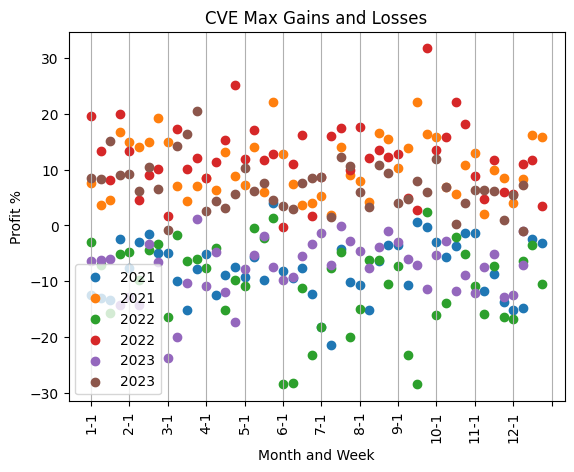

In [13]:
# Group by month and week
grouped = dataset.groupby(['year', 'month and week'])
import matplotlib.pyplot as plt
import numpy as np

# get unique month and week values
month_and_weeks = dataset['month and week'].unique()
# remove '*-5' from month and week
month_and_weeks = [x for x in month_and_weeks if '-5' not in x]

# plot every year's max loss and max gain for each month and week

# plot max loss 
for year in dataset['year'].unique()[-3::]:
    # get data for that year
    year_data = dataset[dataset['year'] == year]
    # get data for those in month_and_weeks
    year_data = year_data[year_data['month and week'].isin(month_and_weeks)]
    # plot
    plt.scatter(year_data['month and week'], year_data['max loss'], label=year)
    plt.scatter(year_data['month and week'], year_data['max gain'], label=year)

# replace x label with month and weeks and rotate
plt.xticks(np.arange(len(month_and_weeks)), month_and_weeks)
plt.grid(axis='x')
# Only show the first label of every month
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))

plt.legend()
# place legend in bottom left
# vertical lines on x axis
plt.legend(loc='lower left')
plt.title('CVE Max Gains and Losses')
plt.xlabel('Month and Week')
plt.ylabel('Profit %')
plt.xticks(rotation=90)
plt.show()


In [4]:
# create dataset grouped by month and week
grouped = dataset.groupby(['year', 'month and week'])

unique_years = dataset['year'].unique()
unique_years_count = len(unique_years)

# create a dataset with month_and_weeks as columns and the average, min, max, and std of max loss and max gain as rows
month_and_weeks = dataset['month and week'].unique()
# remove '*-5' from month and week
month_and_weeks = [x for x in month_and_weeks if '-5' not in x]
# create dataframe
df = pd.DataFrame(columns=['month and week', 'max loss', 'avg loss', 'min loss', 'std loss',  'min gain', 'avg gain','max gain', 'std gain'])
df['month and week'] = month_and_weeks
df = df.set_index('month and week')

# fill in the dataframe
for month_and_week in month_and_weeks:
    # get data for that month and week
    month_and_week_data = dataset[dataset['month and week'] == month_and_week]
    # get loss and gain data
    max_loss_data = month_and_week_data['max loss']
    max_gain_data = month_and_week_data['max gain']
    # fill in the dataframe
    df.at[month_and_week, 'avg loss'] = max_loss_data.mean()
    df.at[month_and_week, 'avg gain'] = max_gain_data.mean()
    df.at[month_and_week, 'min loss'] = max_loss_data.max()
    df.at[month_and_week, 'min gain'] = max_gain_data.min()
    df.at[month_and_week, 'max loss'] = max_loss_data.min()
    df.at[month_and_week, 'max gain'] = max_gain_data.max()
    df.at[month_and_week, 'std loss'] = max_loss_data.std()
    df.at[month_and_week, 'std gain'] = max_gain_data.std()

df['avg gain/loss ratio'] = df['avg gain']+df['avg loss']
df['min gain/loss ratio'] = df['min gain']+df['max loss']
df['max gain/loss ratio'] = df['max gain']+df['min loss']
    
# save df
save_path = r'D:\repo\Stock\Seasonal-Stock\dataset\CVE\data\CVE_grouped_by_month_and_week.csv'
df.to_csv(save_path)